To remove data files

In [ ]:
!rm -rf *

!ls -a

.  ..  .config


Calculate accuracy for probability-approach

In [1]:
import pandas as pd
import glob

def analyze_probability_results_concise():
    files = [f for f in glob.glob("*.csv")
             if not f.startswith("Text")
             and f != "dataset.csv"
             and "summary" not in f]

    results = []
    for filename in files:
        try:
            df = pd.read_csv(filename)

            if 'model_label' not in df.columns:
                print(f"Skipping {filename} (missing columns)")
                continue

            row = df.iloc[0][['model_label', 'setting', 'prompt_type']].to_dict()
            row['accuracy'] = df['chosen_is_correct'].mean()
            row['count'] = len(df)
            row['filename'] = filename
            results.append(row)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    if not results:
        print("No valid files found!")
        return

    summary_df = pd.DataFrame(results)
    summary_df = summary_df.sort_values(by=["model_label", "setting"])

    print(f"\nTotal files processed: {len(results)}")
    print("Probability Approach Accuracy")
    print(summary_df.to_string(index=False, formatters={'accuracy': '{:.2%}'.format}))
    summary_df.to_csv("prob_accuracy_summary.csv", index=False)

if __name__ == "__main__":
    analyze_probability_results_concise()


Total files processed: 40
Probability Approach Accuracy
             model_label            setting prompt_type accuracy  count                                        filename
Mistral-7B-Instruct-v0.3  few_shot_standard    few_shot   70.00%     50  Mistral-7B-Instruct-v0.3_few_shot_standard.csv
Mistral-7B-Instruct-v0.3 zero_shot_standard   zero_shot   48.00%     50 Mistral-7B-Instruct-v0.3_zero_shot_standard.csv
         Mistral-7B-v0.3  few_shot_standard    few_shot   66.00%     50           Mistral-7B-v0.3_few_shot_standard.csv
         Mistral-7B-v0.3 zero_shot_standard   zero_shot   32.00%     50          Mistral-7B-v0.3_zero_shot_standard.csv
          Olmo-3-7B-Base  few_shot_standard    few_shot   58.00%     50            Olmo-3-7B-Base_few_shot_standard.csv
          Olmo-3-7B-Base zero_shot_standard   zero_shot   46.00%     50           Olmo-3-7B-Base_zero_shot_standard.csv
      Olmo-3-7B-Instruct  few_shot_standard    few_shot   60.00%     50        Olmo-3-7B-Instruct_few_s

Calculate accuracy for text-based approach

In [2]:
import pandas as pd
import glob
import os

def analyze_text_based_results_concise():
    files = glob.glob("Text-Based*.csv")

    results = []
    for filename in files:
        df = pd.read_csv(filename)

        model_name = os.path.basename(filename)\
            .replace("Text-Based-inference -output_", "")\
            .replace("Text-Based-output_", "")\
            .replace(".csv", "")

        accuracy = (df['Correct'].astype(str).str.lower() == 'true').mean()

        results.append({
            "Model": model_name,
            "Approach": "Text-Based Generation",
            "Accuracy": accuracy,
            "Count": len(df),
            "Filename": filename
        })

    if results:
        summary_df = pd.DataFrame(results).sort_values(by="Model")

        print(f"\nTotal files processed: {len(results)}")
        print("Text-Based Inference Accuracy")
        print(summary_df.to_string(index=False, formatters={'Accuracy': '{:.2%}'.format}))

        summary_df.to_csv("summary_text_based_accuracy.csv", index=False)

if __name__ == "__main__":
    analyze_text_based_results_concise()


Total files processed: 11
Text-Based Inference Accuracy
              Model              Approach Accuracy  Count                                  Filename
         Mistral-7B Text-Based Generation   26.00%     50          Text-Based-output_Mistral-7B.csv
Mistral-7B-Instruct Text-Based Generation   54.00%     50 Text-Based-output_Mistral-7B-Instruct.csv
     Olmo-3-1025-7B Text-Based Generation   38.00%     50      Text-Based-output_Olmo-3-1025-7B.csv
 Olmo-3-7B-Instruct Text-Based Generation   54.00%     50  Text-Based-output_Olmo-3-7B-Instruct.csv
    Olmo-3-7B-Think Text-Based Generation   46.00%     50     Text-Based-output_Olmo-3-7B-Think.csv
          Qwen3-14B Text-Based Generation   68.00%     50           Text-Based-output_Qwen3-14B.csv
           Qwen3-4B Text-Based Generation   40.00%     50            Text-Based-output_Qwen3-4B.csv
      Qwen3-4B-Base Text-Based Generation   52.00%     50       Text-Based-output_Qwen3-4B-Base.csv
  Qwen3-4B-Instruct Text-Based Generation  

Comparison of two approaches

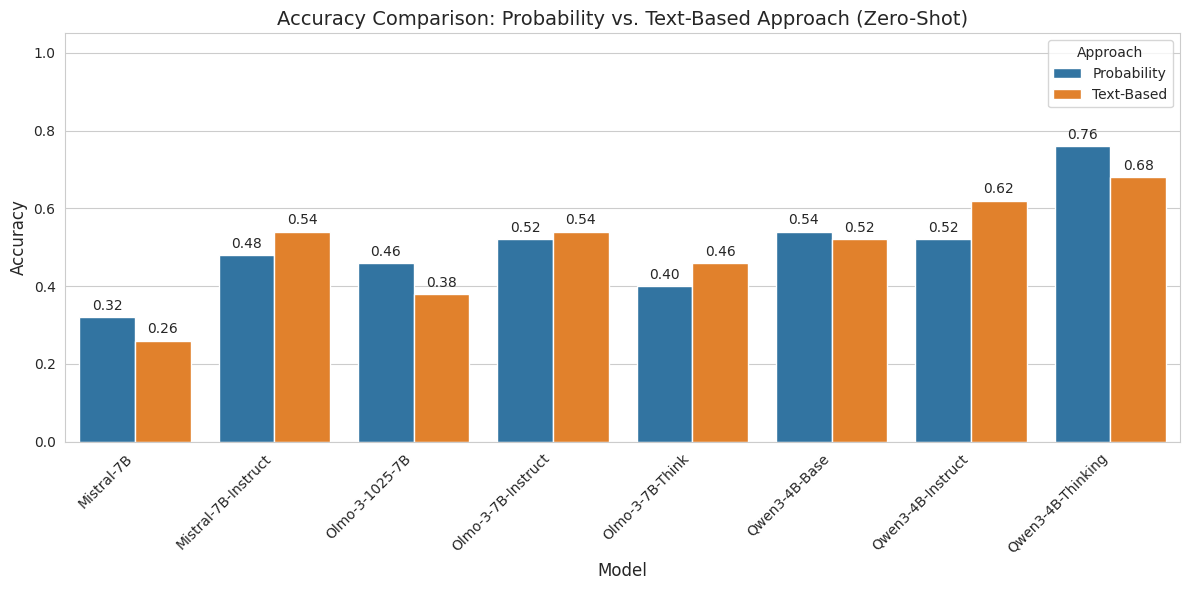

In [8]:
def plot_comparison():
    try:
        prob_df = pd.read_csv("prob_accuracy_summary.csv")
        text_df = pd.read_csv("summary_text_based_accuracy.csv")
    except FileNotFoundError:
        print("Error: Could not find one of the summary CSV files.")
        return

    text_data = text_df[['Model', 'Accuracy']].copy()
    text_data['Approach'] = 'Text-Based'

    prob_zero = prob_df[prob_df['prompt_type'] == 'zero_shot'].copy()

    name_map = {
        'Mistral-7B-Instruct-v0.3': 'Mistral-7B-Instruct',
        'Mistral-7B-v0.3': 'Mistral-7B',
        'Olmo-3-7B-Base': 'Olmo-3-1025-7B',
        'Olmo-3-7B-Instruct': 'Olmo-3-7B-Instruct',
        'Olmo-3-7B-Think': 'Olmo-3-7B-Think',
        'Qwen3-4B-Base': 'Qwen3-4B-Base',
        'Qwen3-4B-Instruct': 'Qwen3-4B-Instruct',
        'Qwen3-4B-Thinking': 'Qwen3-4B-Thinking'
    }

    prob_zero['Mapped_Model'] = prob_zero['model_label'].map(name_map)

    prob_comparable = prob_zero.dropna(subset=['Mapped_Model']).copy()

    prob_grouped = prob_comparable.groupby('Mapped_Model')['accuracy'].max().reset_index()
    prob_grouped['Approach'] = 'Probability'
    prob_grouped.rename(columns={'Mapped_Model': 'Model', 'accuracy': 'Accuracy'}, inplace=True)

    common_models = set(prob_grouped['Model'])
    text_filtered = text_data[text_data['Model'].isin(common_models)].copy()

    combined_df = pd.concat([prob_grouped, text_filtered], ignore_index=True)

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    ax = sns.barplot(
        data=combined_df,
        x='Model',
        y='Accuracy',
        hue='Approach',
        palette=['#1f77b4', '#ff7f0e']
    )

    plt.title('Accuracy Comparison: Probability vs. Text-Based Approach (Zero-Shot)', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.05)
    plt.legend(title='Approach')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)

    plt.tight_layout()
    plt.savefig('accuracy_comparison_plot.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    plot_comparison()

Loaded 40 rows successfully.
RQ 1: Is Few-Shot always better than Zero-Shot?
Total Comparisons Performed: 20
Cases where Few-Shot > Zero-Shot: 18 (90.0%)

[!] EXCEPTIONS FOUND (Zero-Shot >= Few-Shot):
prompt_type                       zero_shot  few_shot  Diff
model_label         setting_base                           
Pythia-6.9b-deduped standard           0.48      0.44 -0.04
Pythia-70m-deduped  standard           0.62      0.60 -0.02

Generating RQ1 Plot...


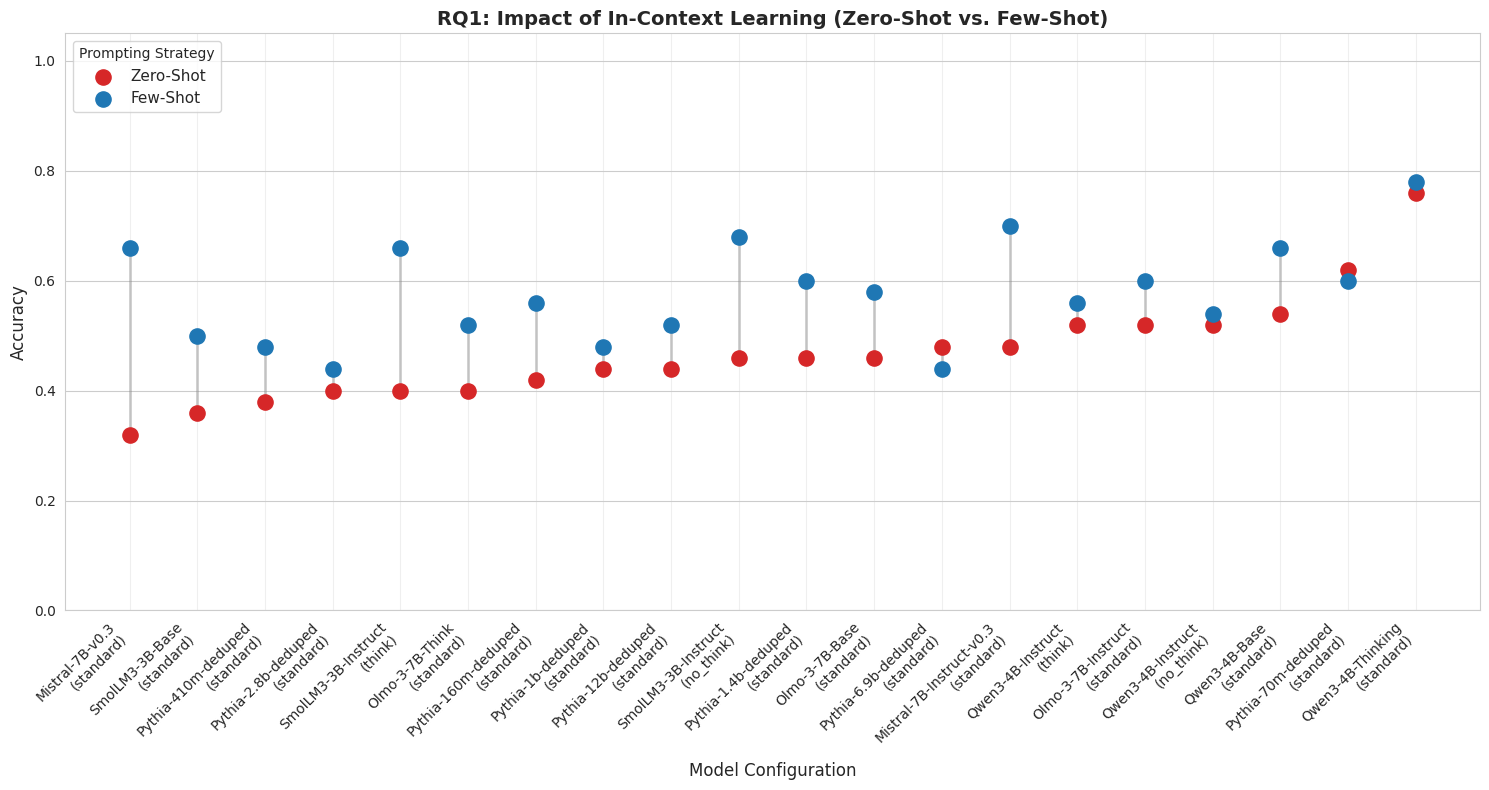

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

# Helper functions

def get_model_size(label):
    label = str(label).lower()
    if "smollm3-3b" in label: return 3.0
    if "mistral-7b" in label: return 7.0
    if "olmo-3" in label and "7b" in label: return 7.0

    match_b = re.search(r'([0-9\.]+)\-?b', label)
    match_m = re.search(r'([0-9\.]+)\-?m', label)

    if match_b:
        return float(match_b.group(1))
    elif match_m:
        return float(match_m.group(1)) / 1000.0
    return None

def get_model_family(label):
    label = str(label).lower()
    if "pythia" in label: return "Pythia"
    if "qwen" in label: return "Qwen"
    if "olmo" in label: return "Olmo"
    if "mistral" in label: return "Mistral"
    if "smollm" in label: return "SmolLM"
    return "Other"

def get_effective_behavior(row):
    label = str(row['model_label']).lower()
    setting = str(row['setting']).lower()

    if "thinking" in label or ("think" in label and "instruct" not in label):
        return "Thinking (Standalone)"
    if "instruct" in label:
        if "no_think" in setting: return "Instruct (No-Think)"
        if "think" in setting and "no_think" not in setting: return "Instruct (Thinking Mode)"
        return "Instruct (Standard)"
    return "Base"

try:
    df = pd.read_csv("prob_accuracy_summary.csv")
    print(f"Loaded {len(df)} rows successfully.")
except FileNotFoundError:
    print("Error: 'prob_accuracy_summary.csv' not found.")
    exit()

df['Size_B'] = df['model_label'].apply(get_model_size)
df['Family'] = df['model_label'].apply(get_model_family)
df['Behavior'] = df.apply(get_effective_behavior, axis=1)
df['setting_base'] = df['setting'].str.replace('zero_shot_', '').str.replace('few_shot_', '')

pivot_shot = df.pivot_table(
    index=['model_label', 'setting_base'],
    columns='prompt_type',
    values='accuracy'
).dropna()

print("RQ 1: Is Few-Shot always better than Zero-Shot?")

pivot_shot['Few_is_Better'] = pivot_shot['few_shot'] > pivot_shot['zero_shot']
pivot_shot['Diff'] = pivot_shot['few_shot'] - pivot_shot['zero_shot']

better_count = pivot_shot['Few_is_Better'].sum()
total_count = len(pivot_shot)

print(f"Total Comparisons Performed: {total_count}")
print(f"Cases where Few-Shot > Zero-Shot: {better_count} ({better_count/total_count:.1%})")

if better_count < total_count:
    print("\n[!] EXCEPTIONS FOUND (Zero-Shot >= Few-Shot):")
    print(pivot_shot[~pivot_shot['Few_is_Better']][['zero_shot', 'few_shot', 'Diff']].to_string())
else:
    print("\n[Result] Yes. Few-Shot outperformed Zero-Shot in 100% of cases.")

# Dumbbell Plot

print("\nGenerating RQ1 Plot...")

plot_data = pivot_shot.reset_index()
plot_data['Label'] = plot_data['model_label'] + "\n(" + plot_data['setting_base'] + ")"
plot_data = plot_data.sort_values('zero_shot')

plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

plt.vlines(
    x=plot_data['Label'],
    ymin=plot_data['zero_shot'],
    ymax=plot_data['few_shot'],
    color='grey',
    alpha=0.4,
    linewidth=2
)

plt.scatter(
    plot_data['Label'],
    plot_data['zero_shot'],
    color='#d62728',
    label='Zero-Shot',
    s=120,
    zorder=3
)

plt.scatter(
    plot_data['Label'],
    plot_data['few_shot'],
    color='#1f77b4',
    label='Few-Shot',
    s=120,
    zorder=3
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model Configuration', fontsize=12)
plt.title('RQ1: Impact of In-Context Learning (Zero-Shot vs. Few-Shot)', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', title="Prompting Strategy", fontsize=11)
plt.ylim(0, 1.05)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.savefig('rq1_few_shot_vs_zero_shot.png', dpi=300)
plt.show()

RQ 2: Effect of Model Alignment (Base vs Instruct vs Thinking)
Average Zero-Shot Accuracy by Alignment Stage:
Variant_Type  Base  Instruct  Thinking (Standalone)
Family                                             
Olmo          0.46      0.52                   0.40
Qwen          0.54      0.52                   0.76

Generating RQ2 Plot...


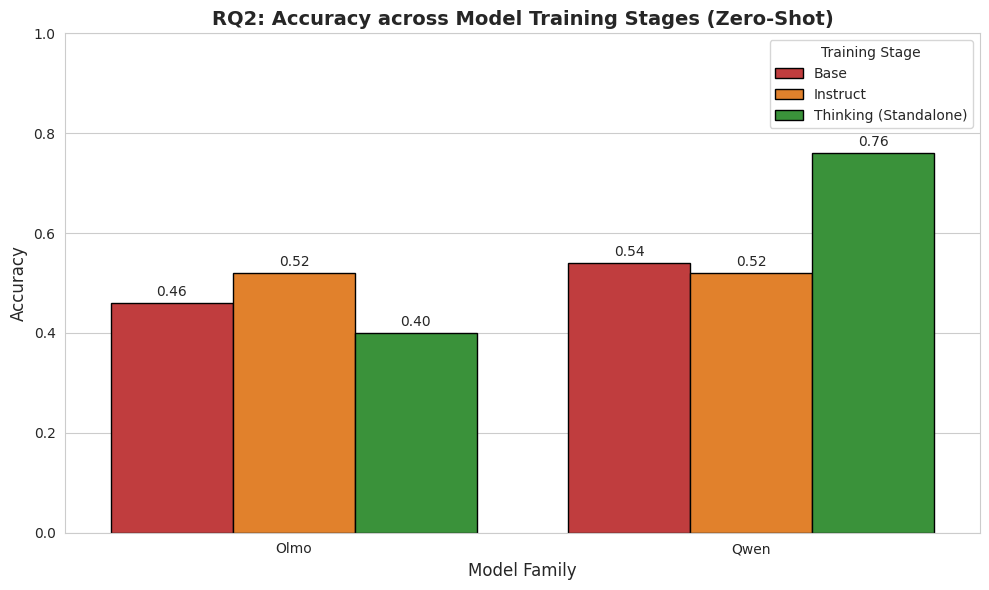

In [4]:
print("RQ 2: Effect of Model Alignment (Base vs Instruct vs Thinking)")

rq2_mask = (df['Family'].isin(['Qwen', 'Olmo'])) & (df['prompt_type'] == 'zero_shot')
df_vars = df[rq2_mask].copy()

df_vars = df_vars[df_vars['Behavior'] != "Instruct (Thinking Mode)"]

def get_variant_highlevel(b):
    if "Base" in b: return "Base"
    if "Thinking (Standalone)" in b: return "Thinking (Standalone)"
    return "Instruct"

df_vars['Variant_Type'] = df_vars['Behavior'].apply(get_variant_highlevel)

var_summary = df_vars.groupby(['Family', 'Variant_Type'])['accuracy'].mean().unstack()
col_order = ['Base', 'Instruct', 'Thinking (Standalone)']
var_summary = var_summary[col_order]

print("Average Zero-Shot Accuracy by Alignment Stage:")
print(var_summary.to_string())

print("\nGenerating RQ2 Plot...")

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

palette = {
    'Base': '#d62728',       # Red
    'Instruct': '#ff7f0e',   # Orange
    'Thinking (Standalone)': '#2ca02c' # Green
}

ax = sns.barplot(
    data=df_vars,
    x='Family',
    y='accuracy',
    hue='Variant_Type',
    hue_order=col_order,
    palette=palette,
    edgecolor='black',
    linewidth=1
)

plt.title('RQ2: Accuracy across Model Training Stages (Zero-Shot)', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model Family', fontsize=12)
plt.ylim(0, 1.0)
plt.legend(title="Training Stage")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.savefig('rq2_model_alignment_comparison.png', dpi=300)
plt.show()

RQ 3: Accuracy vs. Reasoning Modes (Within Instruct Models)
Zero-Shot Accuracy across Inference Modes:
Mode_Label           No-Think  Think
model_label                         
Qwen3-4B-Instruct        0.52   0.52
SmolLM3-3B-Instruct      0.46   0.40

Generating RQ3 Plot...


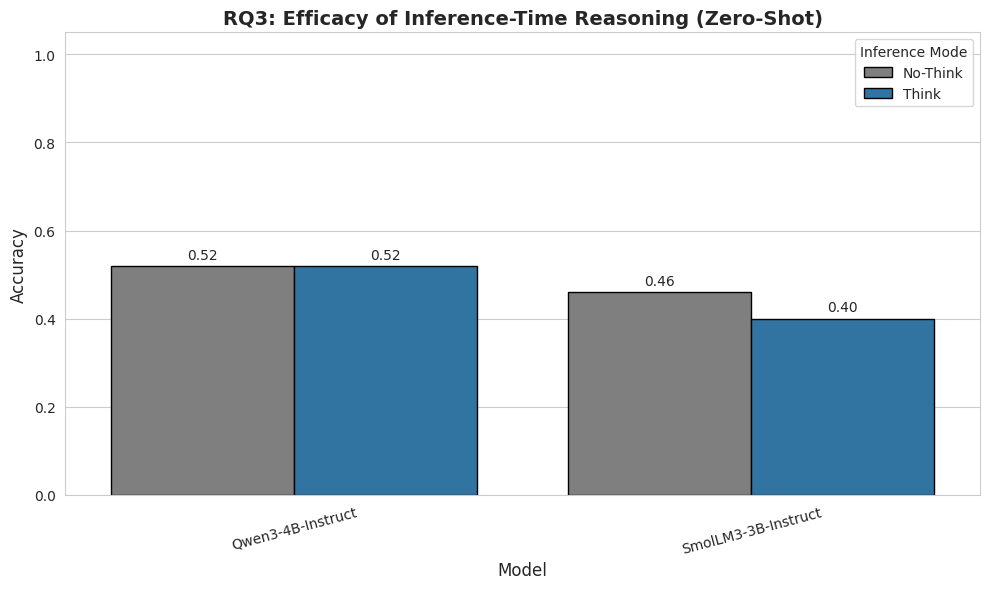

In [5]:
# RQ 3: Efficacy of Inference-Time Reasoning

print("RQ 3: Accuracy vs. Reasoning Modes (Within Instruct Models)")

mode_mask = df['Behavior'].str.contains('Instruct') & \
            (df['setting'].str.contains('think') | df['setting'].str.contains('no_think'))

df_modes = df[mode_mask & (df['prompt_type'] == 'zero_shot')].copy()

if not df_modes.empty:
    def get_clean_mode(s):
        if "no_think" in s: return "No-Think"
        if "think" in s: return "Think"
        return "Standard"

    df_modes['Mode_Label'] = df_modes['setting'].apply(get_clean_mode)

    mode_summary = df_modes.pivot_table(index='model_label', columns='Mode_Label', values='accuracy')
    print("Zero-Shot Accuracy across Inference Modes:")
    print(mode_summary.to_string())

    print("\nGenerating RQ3 Plot...")

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    palette = {'Think': '#1f77b4', 'No-Think': '#7f7f7f'}

    ax = sns.barplot(
        data=df_modes,
        x='model_label',
        y='accuracy',
        hue='Mode_Label',
        palette=palette,
        edgecolor='black'
    )

    plt.title('RQ3: Efficacy of Inference-Time Reasoning (Zero-Shot)', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.ylim(0, 1.05)
    plt.legend(title="Inference Mode")
    plt.xticks(rotation=15)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)

    plt.tight_layout()
    plt.savefig('rq3_inference_mode_comparison.png', dpi=300)
    plt.show()


RQ 4: Scaling Law (Model Size vs. Accuracy)
[OK] All base models have valid parsed sizes.

Data Points for Scaling Analysis (All Base Models):
        model_label  Size_B  accuracy
 Pythia-70m-deduped    0.07      0.62
Pythia-160m-deduped    0.16      0.42
Pythia-410m-deduped    0.41      0.38
  Pythia-1b-deduped    1.00      0.44
Pythia-1.4b-deduped    1.40      0.46
Pythia-2.8b-deduped    2.80      0.40
    SmolLM3-3B-Base    3.00      0.36
      Qwen3-4B-Base    4.00      0.54
Pythia-6.9b-deduped    6.90      0.48
    Mistral-7B-v0.3    7.00      0.32
     Olmo-3-7B-Base    7.00      0.46
 Pythia-12b-deduped   12.00      0.44

Pearson Correlation (Size vs Accuracy): -0.1573


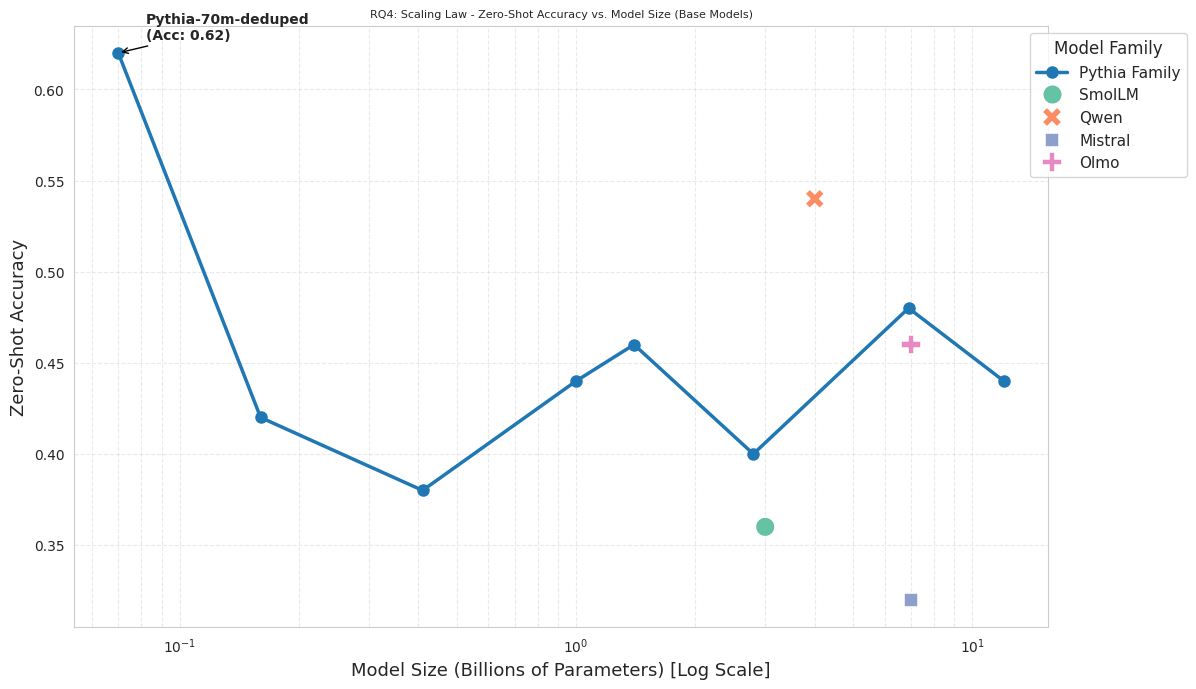

In [9]:
def get_model_size(label):
    label = str(label).lower()
    if "smollm3-3b" in label: return 3.0
    if "mistral-7b" in label: return 7.0
    if "olmo-3" in label and "7b" in label: return 7.0

    match_b = re.search(r'(\d+(?:\.\d+)?)\s*-?b', label)
    if match_b:
        return float(match_b.group(1))

    match_m = re.search(r'(\d+(?:\.\d+)?)\s*-?m', label)
    if match_m:
        return float(match_m.group(1)) / 1000.0

    return None

df['Size_B'] = df['model_label'].apply(get_model_size)
df['Family'] = df['model_label'].apply(get_model_family)
df['Behavior'] = df.apply(get_effective_behavior, axis=1)

print("RQ 4: Scaling Law (Model Size vs. Accuracy)")

scaling_mask = (df['Behavior'] == 'Base') & (df['prompt_type'] == 'zero_shot')
df_scaling = df[scaling_mask].copy()

df_scaling = df_scaling.sort_values('Size_B')

missing_sizes = df_scaling[df_scaling['Size_B'].isna()]
if not missing_sizes.empty:
    print("[WARNING] The following models have NaN size:")
    print(missing_sizes['model_label'].tolist())
else:
    print("[OK] All base models have valid parsed sizes.")

print("\nData Points for Scaling Analysis (All Base Models):")
print(df_scaling[['model_label', 'Size_B', 'accuracy']].to_string(index=False))

if len(df_scaling) > 2:
    corr = df_scaling['Size_B'].corr(df_scaling['accuracy'])
    print(f"\nPearson Correlation (Size vs Accuracy): {corr:.4f}")

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")

    pythia_data = df_scaling[df_scaling['Family'] == 'Pythia']
    plt.plot(
        pythia_data['Size_B'],
        pythia_data['accuracy'],
        marker='o',
        linestyle='-',
        linewidth=2.5,
        label='Pythia Family',
        color='#1f77b4',
        markersize=8
    )

    other_data = df_scaling[df_scaling['Family'] != 'Pythia']

    sns.scatterplot(
        data=other_data,
        x='Size_B',
        y='accuracy',
        hue='Family',
        style='Family',
        s=200,
        zorder=5,
        palette='Set2'
    )

    plt.xscale('log')
    plt.title('RQ4: Scaling Law - Zero-Shot Accuracy vs. Model Size (Base Models)', fontsize=8)
    plt.xlabel('Model Size (Billions of Parameters) [Log Scale]', fontsize=13)
    plt.ylabel('Zero-Shot Accuracy', fontsize=13)

    plt.legend(title="Model Family", fontsize=11, title_fontsize=12, loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True, which="both", ls="--", alpha=0.4)

    best_small = pythia_data.loc[pythia_data['Size_B'].idxmin()]
    plt.annotate(
        f"{best_small['model_label']}\n(Acc: {best_small['accuracy']:.2f})",
        (best_small['Size_B'], best_small['accuracy']),
        xytext=(20, 10), textcoords='offset points',
        arrowprops=dict(arrowstyle="->", color='black'),
        fontsize=10, fontweight='bold'
    )

    plt.tight_layout()
    plt.savefig('scaling_law_plot_fixed.png', dpi=300)
    plt.show()